In [1]:
import pandas as pd
import os
import matplotlib
%matplotlib inline
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [2]:
# for dirname, _, filenames in os.walk('/mnt/'):
#     for filename in filenames:
#         print(os.path.join(dirname,filename))

In [3]:
train_data = pd.read_csv('/mnt/cs-training.csv')

In [4]:
train_data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
train_data_input = train_data.loc[:,~train_data.columns.isin(['Unnamed: 0','SeriousDlqin2yrs'])]

In [6]:
train_data_input.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [7]:
train_data_output = train_data[['SeriousDlqin2yrs']]

In [8]:
train_data_output.head()

,SeriousDlqin2yrs
0,1
1,0
2,0
3,0
4,0


In [9]:
train_data_input.shape

(150000, 10)

In [10]:
train_data_output.shape

(150000, 1)

## Data Exploration

### Exploring Output Data

In [11]:
output_stat = Counter(train_data_output.SeriousDlqin2yrs)

In [12]:
print("Percentage of Customers who default are: "+str(round(output_stat[1]*100/(output_stat[0]+output_stat[1]),2))+"%")

Percentage of Customers who default are: 6.68%


In [13]:
print("Percentage of Customers who do not default are: "+str(round(output_stat[0]*100/(output_stat[0]+output_stat[1]),2))+"%")


Percentage of Customers who do not default are: 93.32%


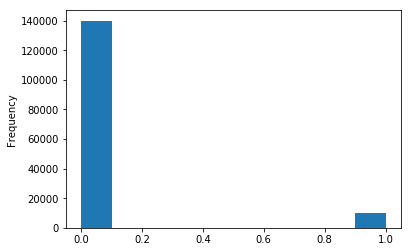

In [14]:
train_data_output['SeriousDlqin2yrs'].plot.hist()

In [15]:
#Note: the data above is an example of class imbalance having the ration of 7:93
## Generally there are two approaches to handle class imbalance:
## a. sampling based
## b. cost based 

# Lets read through this on Class imbalance: 
## https://machinelearningmastery.com/what-is-imbalanced-classification/
## https://towardsdatascience.com/guide-to-classification-on-imbalanced-datasets-d6653aa5fa23

### Exploring Input Features

#### RevolvingUtilizationOfUnsecuredLines

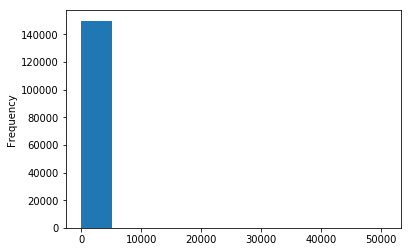

In [16]:
train_data_input['RevolvingUtilizationOfUnsecuredLines'].plot.hist()

In [17]:
train_data['RevolvingUtilizationOfUnsecuredLines'].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

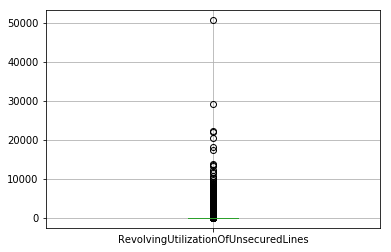

In [18]:
# Indentifying if ReveolvingUtilizationOfUnsecuredLines has any otliers
## Link on article about Outlier detection: https://machinelearningmastery.com/how-to-identify-outliers-in-your-data/

#Approach 1: Extreme Value Analysis
# https://heartbeat.fritz.ai/how-to-make-your-machine-learning-models-robust-to-outliers-44d404067d07
## Interquartile range is given by, IQR = Q3 — Q1 
## Upper limit = Q3+1.5*IQR 
## Lower limit = Q1–1.5*IQR 
## Anything below the lower limit and above the upper limit is considered an outlier

train_data_input[['RevolvingUtilizationOfUnsecuredLines']].boxplot()

In [19]:
q_1 = train_data['RevolvingUtilizationOfUnsecuredLines'].describe()['25%']
q_3 = train_data['RevolvingUtilizationOfUnsecuredLines'].describe()['75%']
inter_quartile_range =  round(q_3 - q_1,2)
upper_limit_outlier = round(q_3 + 1.5*inter_quartile_range,2)
lower_limit_outlier = round(q_3 - 1.5*inter_quartile_range,2)

In [20]:
inter_quartile_range, lower_limit_outlier, upper_limit_outlier

(0.53, -0.24, 1.35)

In [21]:
outlier_count = 0
for i in train_data_input['RevolvingUtilizationOfUnsecuredLines']:
    if i > upper_limit_outlier or i < lower_limit_outlier:
        outlier_count+=1

print("Percentage datapoints of RevolvingUtilizationOfUnsecuredLines that are outliers is "+str(outlier_count*100/len(train_data_input['RevolvingUtilizationOfUnsecuredLines']))+"%")


Percentage datapoints of RevolvingUtilizationOfUnsecuredLines that are outliers is 0.51%


In [22]:
# Next: How to deal with these outliers? Should they be removed, imputed, etc?

## Build Logistic Regression Model

In [23]:
model = LogisticRegression()

In [24]:
train_data_input.fillna(value=0,inplace=True)

/usr/local/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [25]:
model.fit(train_data_input,train_data_output)

/usr/local/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
predicted_ouput = model.predict(train_data_input)

In [27]:
print(classification_report(train_data_output['SeriousDlqin2yrs'],predicted_ouput))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97    139974
          1       0.55      0.04      0.07     10026

avg / total       0.91      0.93      0.91    150000



##### Vanilla Logistic Regression has a Recall of 4% and a Precision of 55%. This will be our benchmark.